<h1><center> Image Classification for Skin Lesion Diagnosis</center><h1>
<h4><center> Red Dragon AI Deep Learning Jumpstart Workshop Project </center><h4>
<h5><center> Wong Jia Hwee </center><h5>


Skin lesions are a symptom of skin cancer. However, they may look similar to a regular skin mole. Early detection of skin lesions may allow for earlier treatment for skin lesions.

In this project, given images of moles and skin lesion, I would like to apply transfer learning and to build simple CNN from scratch to classify the images to their respective conditions that caused them.

The data is obtained from https://www.kaggle.com/fanconic/skin-cancer-malignant-vs-benign.

## Import Libraries and Data

In [ ]:
!nvidia-smi

Wed Dec 30 07:41:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import pandas as pd
import os
import glob
import random
import itertools

import tensorflow as tf
import tensorflow.keras

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import EfficientNetB1, InceptionResNetV2
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions

from tensorflow.keras.models import Model, load_model, Sequential

from tensorflow.keras.layers import Dense, Conv1D, Conv2D
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D,Dropout, Flatten, Input

from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from sklearn.metrics import confusion_matrix, recall_score

from IPython.display import Image

In [ ]:
print(tf.keras.__version__)
print(tf.__version__)

2.4.0
2.4.0


In [ ]:
# Data
!wget -qq https://www.dropbox.com/s/782rc6tyc1jsgot/skin_lesion_data.zip

In [ ]:
!ls

sample_data  skin_lesion_data.zip


In [ ]:
!unzip -qq skin_lesion_data.zip
!rm skin_lesion_data.zip

!ls

sample_data  skin_lesion_test  skin_lesion_train


In [ ]:
PROJ_DIR = "/content/drive/MyDrive/Red Dragon AI/Module 1/Project/"
MODELS_DIR = "/content/drive/MyDrive/Red Dragon AI/Module 1/Project/models/"
TRAIN_DIR = "/content/skin_lesion_train"
TEST_DIR = "/content/skin_lesion_test"

## Setting Things Up

In [ ]:
data = []
for root, dirs, files in os.walk(TRAIN_DIR, topdown=True): # walk through the directory
  for name in files:
    if '.jpg' not in name:
      continue
    filename = os.path.abspath(os.path.join(root, name))
    class_name = os.path.basename(root)
    data.append((filename, class_name))

train_df = pd.DataFrame(data, columns=['filename','class_name'])

train_df['class_name'] = train_df['class_name'].astype('category')
train_df['class'] = train_df['class_name'].cat.codes

# Shuffle
train_df = train_df.sample(frac=1).reset_index(drop=True)

display(train_df.head())
print(train_df.shape)
print(train_df.dtypes)

,filename,class_name,class
0,/content/skin_lesion_train/malignant/1249.jpg,malignant,1
1,/content/skin_lesion_train/malignant/659.jpg,malignant,1
2,/content/skin_lesion_train/malignant/245.jpg,malignant,1
3,/content/skin_lesion_train/malignant/377.jpg,malignant,1
4,/content/skin_lesion_train/malignant/1134.jpg,malignant,1


(2637, 3)
filename        object
class_name    category
class             int8
dtype: object


In [ ]:
train_df.iloc[0,0]

'/content/skin_lesion_train/malignant/1249.jpg'

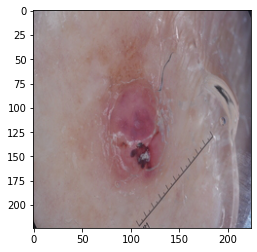

In [ ]:
img = mpimg.imread("/content/skin_lesion_train/malignant/583.jpg")
plt.imshow(img)

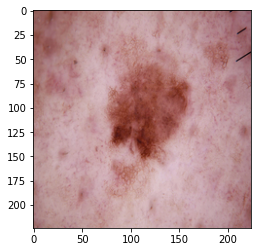

In [ ]:
img = mpimg.imread(train_df.iloc[0,0])
plt.imshow(img)

In [ ]:
data = []
for root, dirs, files in os.walk(TEST_DIR, topdown=True): # walk through the directory
  for name in files:
    if '.jpg' not in name:
      continue
    filename = os.path.abspath(os.path.join(root, name))
    class_name = os.path.basename(root)
    data.append((filename, class_name))

test_df = pd.DataFrame(data, columns=['filename','class_name'])

test_df['class_name'] = test_df['class_name'].astype('category')
test_df['class'] = test_df['class_name'].cat.codes

# Shuffle
test_df = test_df.sample(frac=1).reset_index(drop=True)

display(test_df.head())
print(test_df.shape)
print(test_df.dtypes)

,filename,class_name,class
0,/content/skin_lesion_test/benign/154.jpg,benign,0
1,/content/skin_lesion_test/malignant/200.jpg,malignant,1
2,/content/skin_lesion_test/benign/1297.jpg,benign,0
3,/content/skin_lesion_test/malignant/232.jpg,malignant,1
4,/content/skin_lesion_test/benign/1628.jpg,benign,0


(660, 3)
filename        object
class_name    category
class             int8
dtype: object


## Data Exploration

benign       1440
malignant    1197
Name: class_name, dtype: int64


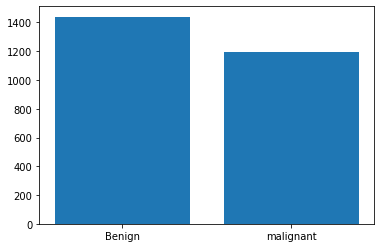

In [ ]:
plt.bar(['Benign', 'malignant'], train_df['class_name'].value_counts())
print(train_df['class_name'].value_counts())

The training set is quite balanced, with 1440 `benign` images and 1197 `malignant` images.

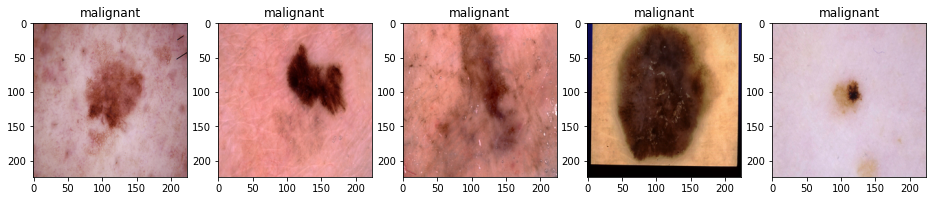

In [ ]:
fig = plt.figure(figsize=(16,16))
cols = 5
rows = 1
df_row = 0
for i in range(1, cols*rows + 1):
  img = mpimg.imread(train_df.iloc[df_row,0])
  class_name = train_df.iloc[df_row,1]
  df_row += 1
  ax = fig.add_subplot(rows, cols, i)
  ax.set_title(class_name)
  plt.imshow(img)
plt.show()

## Data Preprocessing

### Train-Val Split

Let's split the data with 75% of the training images for training and 25% for validation.

In [ ]:
train_set_perc = 0.75

train_set = train_df[:int(len(train_df) * train_set_perc)]
val_set = train_df[int(len(train_df) * train_set_perc):]

# shuffle
train_set = train_set.sample(frac=1).reset_index(drop=True)
val_set = val_set.sample(frac=1).reset_index(drop=True)

display(train_set.head(3))
display(val_set.head(3))
print(train_set.shape)
print(val_set.shape)

,filename,class_name,class
0,/content/skin_lesion_train/benign/103.jpg,benign,0
1,/content/skin_lesion_train/benign/1410.jpg,benign,0
2,/content/skin_lesion_train/malignant/854.jpg,malignant,1


,filename,class_name,class
0,/content/skin_lesion_train/benign/571.jpg,benign,0
1,/content/skin_lesion_train/malignant/392.jpg,malignant,1
2,/content/skin_lesion_train/benign/1452.jpg,benign,0


(1977, 3)
(660, 3)


### Making the pipeline for loading and resizing the images

In [ ]:
img_rows, img_cols = 299, 299
num_classes = 2
batch_size = 64

In [ ]:
def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string, channels=3)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized, shape=(img_rows, img_cols, 3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label

### Assembling the Data Pipeline Using `tf.data`

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(train_set['filename'].values, tf.string),
                                                   tf.cast(train_set['class'].values, tf.int32)))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)                                      

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(val_set['filename'].values, tf.string),
                                                   tf.cast(val_set['class'].values, tf.int32)))
val_dataset = val_dataset.map(_parse_function)
val_dataset = val_dataset.shuffle(5000)
val_dataset = val_dataset.repeat()
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)            

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(test_df['filename'].values, tf.string),
                                                   tf.cast(test_df['class'].values, tf.int32)))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.shuffle(5000)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)   

In [ ]:
train_dataset

<BatchDataset shapes: ((64, 299, 299, 3), (64, 2)), types: (tf.float32, tf.float32)>

## Transfer Learning

We will attempt transfer learning using `EfficientNetB1` and `Inception-ResNet-V2`.

In [ ]:
train_steps = int(len(train_set)/batch_size)
val_steps = int(len(val_set)/batch_size)

print(train_steps)
print(val_steps)

30
10


In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.01)

In [ ]:
metric = 'Recall'

We will use `Recall` as our metric because, in the context of this project, there is a high cost associated with False Negative. We want to reduce false negatives as much as possible.

### `EfficientNetB1`

In [ ]:
base_model_EffNetB1 = EfficientNetB1(weights='imagenet', include_top=False,
                                  input_shape=(299, 299, 3), pooling = None)

In [ ]:
base_model_EffNetB1.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 299, 299, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 299, 299, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization_2[0][0]            
_____________________________________________________________________________________

In [ ]:
# Adding our own layers

base_model_EffNetB1_output = base_model_EffNetB1.output

x = GlobalAveragePooling2D()(base_model_EffNetB1_output)
x = Dense(1280, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(320, activation = 'relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation = 'softmax')(x)

In [ ]:
model_EffNetB1 = Model(inputs=base_model_EffNetB1.input, outputs=predictions)

In [ ]:
model_EffNetB1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 299, 299, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 299, 299, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization_2[0][0]            
____________________________________________________________________________________________

In [ ]:
# Freeze the pre-trained layers
for layer in base_model_EffNetB1.layers:
  layer.trainable = False
  print(layer.name, ' Trainable = ', layer.trainable)

input_3  Trainable =  False
rescaling_2  Trainable =  False
normalization_2  Trainable =  False
stem_conv_pad  Trainable =  False
stem_conv  Trainable =  False
stem_bn  Trainable =  False
stem_activation  Trainable =  False
block1a_dwconv  Trainable =  False
block1a_bn  Trainable =  False
block1a_activation  Trainable =  False
block1a_se_squeeze  Trainable =  False
block1a_se_reshape  Trainable =  False
block1a_se_reduce  Trainable =  False
block1a_se_expand  Trainable =  False
block1a_se_excite  Trainable =  False
block1a_project_conv  Trainable =  False
block1a_project_bn  Trainable =  False
block1b_dwconv  Trainable =  False
block1b_bn  Trainable =  False
block1b_activation  Trainable =  False
block1b_se_squeeze  Trainable =  False
block1b_se_reshape  Trainable =  False
block1b_se_reduce  Trainable =  False
block1b_se_expand  Trainable =  False
block1b_se_excite  Trainable =  False
block1b_project_conv  Trainable =  False
block1b_project_bn  Trainable =  False
block1b_drop  Trainabl

In [ ]:
model_EffNetB1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 299, 299, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 299, 299, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization_2[0][0]            
____________________________________________________________________________________________

In [ ]:
model_EffNetB1.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=[metric])

In [ ]:
checkpoint_EffNetB1 = ModelCheckpoint(MODELS_DIR + 'EffNetB1_weights.hdf5', monitor='val_recall',verbose=1,
                                   save_best_only=True, mode='auto')

early_stopping = EarlyStopping(monitor='val_recall', min_delta=0, patience=5, verbose = 1, mode= 'auto')

In [ ]:
history = model_EffNetB1.fit(train_dataset,
                    steps_per_epoch = train_steps,
                    epochs = 30,
                    validation_data = val_dataset,
                    validation_steps = val_steps,
                    callbacks = [checkpoint_EffNetB1, early_stopping])

Epoch 1/30
30/30 [==============================] - 29s 663ms/step - loss: 0.2456 - recall: 0.8927 - val_loss: 0.5681 - val_recall: 0.8328

Epoch 00001: val_recall did not improve from 0.82344
Epoch 2/30
30/30 [==============================] - 18s 616ms/step - loss: 0.2367 - recall: 0.8891 - val_loss: 0.5403 - val_recall: 0.8359

Epoch 00002: val_recall did not improve from 0.82344
Epoch 3/30
30/30 [==============================] - 18s 619ms/step - loss: 0.2523 - recall: 0.8922 - val_loss: 0.5125 - val_recall: 0.8344

Epoch 00003: val_recall did not improve from 0.82344
Epoch 4/30
30/30 [==============================] - 18s 623ms/step - loss: 0.2689 - recall: 0.8828 - val_loss: 0.5260 - val_recall: 0.8406

Epoch 00004: val_recall did not improve from 0.82344
Epoch 5/30
30/30 [==============================] - 18s 615ms/step - loss: 0.2382 - recall: 0.8917 - val_loss: 0.5928 - val_recall: 0.8344

Epoch 00005: val_recall did not improve from 0.82344
Epoch 6/30
30/30 [=================

In [ ]:
model_EffNetB1.load_weights(MODELS_DIR + 'EffNetB1_weights.hdf5')

#### Evaluating `EfficientNetB1`

Let us first look at the model's evaluation on some random unseen test images. Then, we will evaluate the model on the whole test set to check its overall performance on unseen test data.

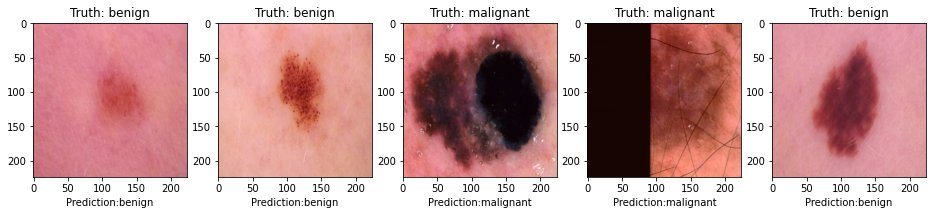

In [ ]:
fig = plt.figure(figsize=(16,16))
cols = 5
rows = 1

for i in range(1, cols*rows + 1):

  df_row = random.randint(0,len(test_df)-1)
  img_path = test_df.iloc[df_row,0]
  class_name = test_df.iloc[df_row,1]

  ax = fig.add_subplot(rows, cols, i)
  ax.set_title("Truth: " + class_name)

  single_test_img = image.load_img(img_path, target_size=(299,299))
  x = image.img_to_array(single_test_img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  pred = model_EffNetB1.predict(x)
  # print(pred)
  if pred[0][0] > pred[0][1]:
    pred_name = 'benign'
  else:
    pred_name = 'malignant'
  ax.set_xlabel("Prediction:" + pred_name)

  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

So far, the model has correctly predicted most of the above individual images. Let us now evaluate it on the whole dataset.

In [ ]:
preds_EffNetB1 = model_EffNetB1.predict(test_dataset, batch_size=batch_size, steps = 10, verbose = 1)
preds_EffNetB1 = preds_EffNetB1.argmax(axis=-1)
preds_EffNetB1.shape

10/10 [==============================] - 7s 319ms/step


(640,)

In [ ]:
test_labels = test_df[:preds_EffNetB1.shape[0]]['class'].to_list()

In [ ]:
recall_score_EffNetB1 = recall_score(test_labels, preds_EffNetB1)
print(recall_score_EffNetB1)

0.5363321799307958


In [ ]:
conf_mat_EffNetB1 = confusion_matrix(test_labels, preds_EffNetB1)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="green" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.5042735  0.4957265 ]
 [0.46366782 0.53633218]]


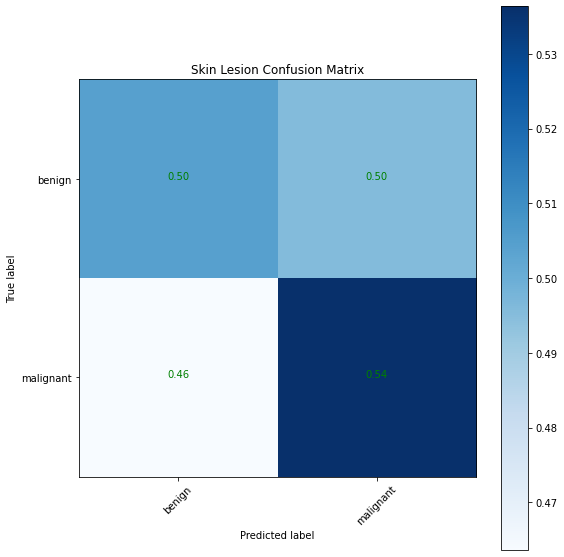

In [ ]:
cm_plot_labels = ('benign', 'malignant')

# # Plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(conf_mat_EffNetB1, cm_plot_labels, normalize=True,
                      title='Skin Lesion Confusion Matrix')

plt.show()

The test recall score is only about between 0.5 to 0.6 which is quite poor. Looking at the confusion matrix, we can see that the model does not perform very well in its classification on the test data.

### `Inception-ResNet-V2`

In [ ]:
base_model_IRNV2 = InceptionResNetV2(weights='imagenet', include_top=False,
                                  input_shape=(299, 299, 3), pooling = None)

219062272/219055592 [==============================] - 3s 0us/step


In [ ]:
base_model_IRNV2.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [ ]:
# Adding our own layers

base_model_IRNV2_output = base_model_IRNV2.output

x = GlobalAveragePooling2D()(base_model_IRNV2_output)
x = Dense(1536, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(384, activation = 'relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation = 'softmax')(x)

In [ ]:
model_IRNV2 = Model(inputs=base_model_IRNV2.input, outputs=predictions)

In [ ]:
model_IRNV2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [ ]:
# Freeze the pre-trained layers
for layer in base_model_IRNV2.layers:
  layer.trainable = False
  print(layer.name, ' Trainable = ', layer.trainable)

input_4  Trainable =  False
conv2d  Trainable =  False
batch_normalization  Trainable =  False
activation  Trainable =  False
conv2d_1  Trainable =  False
batch_normalization_1  Trainable =  False
activation_1  Trainable =  False
conv2d_2  Trainable =  False
batch_normalization_2  Trainable =  False
activation_2  Trainable =  False
max_pooling2d  Trainable =  False
conv2d_3  Trainable =  False
batch_normalization_3  Trainable =  False
activation_3  Trainable =  False
conv2d_4  Trainable =  False
batch_normalization_4  Trainable =  False
activation_4  Trainable =  False
max_pooling2d_1  Trainable =  False
conv2d_8  Trainable =  False
batch_normalization_8  Trainable =  False
activation_8  Trainable =  False
conv2d_6  Trainable =  False
conv2d_9  Trainable =  False
batch_normalization_6  Trainable =  False
batch_normalization_9  Trainable =  False
activation_6  Trainable =  False
activation_9  Trainable =  False
average_pooling2d  Trainable =  False
conv2d_5  Trainable =  False
conv2d_7 

In [ ]:
model_IRNV2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [ ]:
checkpoint_IRNV2 = ModelCheckpoint(MODELS_DIR + 'IRNV2_weights.hdf5', monitor='val_recall',verbose=1,
                                   save_best_only=True, mode='auto')

In [ ]:
model_IRNV2.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=[metric])

In [ ]:
history = model_IRNV2.fit(train_dataset,
                    steps_per_epoch = train_steps,
                    epochs = 30,
                    validation_data = val_dataset,
                    validation_steps = val_steps,
                    callbacks = [checkpoint_IRNV2, early_stopping])

Epoch 1/30
30/30 [==============================] - 34s 839ms/step - loss: 0.6896 - recall: 0.5432 - val_loss: 0.6885 - val_recall: 0.5500

Epoch 00001: val_recall did not improve from 0.54062
Epoch 2/30
30/30 [==============================] - 25s 836ms/step - loss: 0.6892 - recall: 0.5474 - val_loss: 0.6880 - val_recall: 0.5516

Epoch 00002: val_recall did not improve from 0.54062
Epoch 3/30
30/30 [==============================] - 25s 835ms/step - loss: 0.6897 - recall: 0.5432 - val_loss: 0.6893 - val_recall: 0.5453

Epoch 00003: val_recall did not improve from 0.54062
Epoch 4/30
30/30 [==============================] - 25s 835ms/step - loss: 0.6884 - recall: 0.5495 - val_loss: 0.6881 - val_recall: 0.5516

Epoch 00004: val_recall did not improve from 0.54062
Epoch 5/30
30/30 [==============================] - 25s 837ms/step - loss: 0.6895 - recall: 0.5432 - val_loss: 0.6887 - val_recall: 0.5484

Epoch 00005: val_recall did not improve from 0.54062
Epoch 6/30
30/30 [=================

In [ ]:
model_IRNV2.load_weights(MODELS_DIR + 'IRNV2_weights.hdf5')

#### Evaluating `Inception-ResNet-V2`

Let us first look at the model's evaluation on some random unseen test images. Then, we will evaluate the model on the whole test set to check its overall performance on unseen test data.

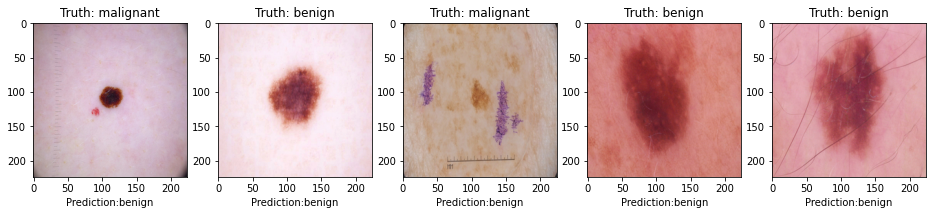

In [ ]:
fig = plt.figure(figsize=(16,16))
cols = 5
rows = 1

for i in range(1, cols*rows + 1):

  df_row = random.randint(0,len(test_df)-1)
  img_path = test_df.iloc[df_row,0]
  class_name = test_df.iloc[df_row,1]

  ax = fig.add_subplot(rows, cols, i)
  ax.set_title("Truth: " + class_name)

  single_test_img = image.load_img(img_path, target_size=(299,299))
  x = image.img_to_array(single_test_img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  pred = model_IRNV2.predict(x)
  # print(pred)
  if pred[0][0] > pred[0][1]:
    pred_name = 'benign'
  else:
    pred_name = 'malignant'
  ax.set_xlabel("Prediction:" + pred_name)

  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

It appears that the model predicts all the images to be `benign`. Let us now evaluate it on the whole dataset.

In [ ]:
preds_IRNV2 = model_IRNV2.predict(test_dataset, batch_size=batch_size, steps = 10, verbose = 1)
preds_IRNV2 = preds_IRNV2.argmax(axis=-1)
preds_IRNV2.shape

10/10 [==============================] - 8s 493ms/step


(640,)

In [ ]:
test_labels = test_df[:preds_IRNV2.shape[0]]['class'].to_list()

In [ ]:
recall_score_IRNV2 = recall_score(test_labels, preds_IRNV2)
print(recall_score_IRNV2)

0.0


In [ ]:
conf_mat_IRNV2 = confusion_matrix(test_labels, preds_IRNV2)

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


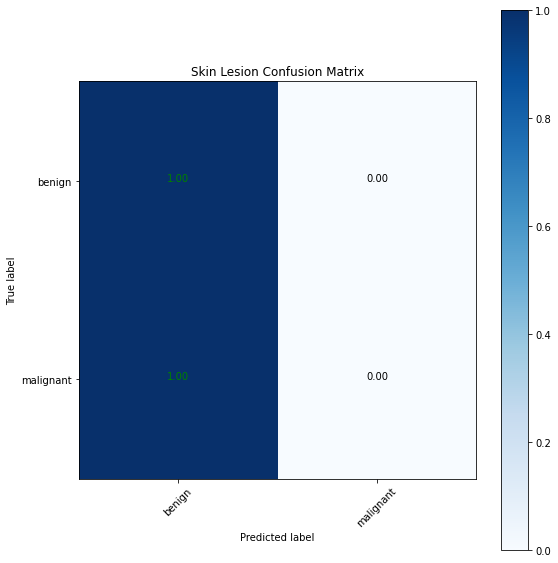

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(conf_mat_IRNV2, cm_plot_labels, normalize=True,
                      title='Skin Lesion Confusion Matrix')

plt.show()

Clearly, `Inception-ResNet-V2` is not able to generalize to unseen data and predicts every image to be from the `benign` class. Indeed, the model has a test recall score of 0.

The model has both train and validation recall score at about 0.55 which is not very high. This shows that the CNN is unable to learn patterns in the image data very well.

## Building My Own CNN From Scratch

Now, having tried tranfer learning, let us now try to build a custom CNN.

In [ ]:
input_shape = (img_rows, img_cols, 3)

In [ ]:
input = Input(shape=input_shape)
x = Conv2D(64, kernel_size=(3,3), activation = 'relu', name = 'Conv_01')(input)
x = MaxPooling2D(pool_size=(2,2), name = 'MaxPool_01')(x)
x = Conv2D(128, kernel_size = (3,3), activation = 'relu', name = 'Conv_02')(x)
x = MaxPooling2D(pool_size=(2,2), name = 'MaxPool_02')(x)
x = Conv2D(256, kernel_size=(5,5), activation = 'relu', name = 'Conv_0.3')(x)
x = Flatten(name = 'Flatten_01')(x)
x = Dense(256, activation = 'relu', name = 'Dense_01')(x)
x = Dropout(0.5, name = 'Dropout_01')(x)
x = Dense(64, activation = 'relu', name = 'Dense_02')(x)
x = Dropout(0.3, name = 'Dropout_02')(x)
output = Dense(2, activation='softmax', name= 'Dense_03')(x)

In [ ]:
model_scratch_CNN = Model(input, output, name='scratch_CNN_model')

In [ ]:
model_scratch_CNN.summary()

Model: "scratch_CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
Conv_01 (Conv2D)             (None, 297, 297, 64)      1792      
_________________________________________________________________
MaxPool_01 (MaxPooling2D)    (None, 148, 148, 64)      0         
_________________________________________________________________
Conv_02 (Conv2D)             (None, 146, 146, 128)     73856     
_________________________________________________________________
MaxPool_02 (MaxPooling2D)    (None, 73, 73, 128)       0         
_________________________________________________________________
Conv_0.3 (Conv2D)            (None, 69, 69, 256)       819456    
_________________________________________________________________
Flatten_01 (Flatten)         (None, 1218816)     

In [ ]:
model_scratch_CNN.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=[metric])

In [ ]:
checkpoint_scratch_CNN = ModelCheckpoint(MODELS_DIR + 'scratch_CNN_weights.hdf5', monitor='val_recall',verbose=1,
                                   save_best_only=True, mode='auto')

In [ ]:
history = model_scratch_CNN.fit(train_dataset,
                    steps_per_epoch = train_steps,
                    epochs = 30,
                    validation_data = val_dataset,
                    validation_steps = val_steps,
                    callbacks = [checkpoint_scratch_CNN, early_stopping])

Epoch 1/30
30/30 [==============================] - 29s 623ms/step - loss: 18402048.2136 - recall: 0.5192 - val_loss: 0.6908 - val_recall: 0.5469

Epoch 00001: val_recall improved from inf to 0.54688, saving model to /content/drive/MyDrive/Red Dragon AI/Module 1/Project/models/scratch_CNN_weights.hdf5
Epoch 2/30
30/30 [==============================] - 22s 732ms/step - loss: 0.6932 - recall: 0.5519 - val_loss: 0.6903 - val_recall: 0.5484

Epoch 00002: val_recall did not improve from 0.54688
Epoch 3/30
30/30 [==============================] - 19s 633ms/step - loss: 0.6902 - recall: 0.5512 - val_loss: 0.6878 - val_recall: 0.5531

Epoch 00003: val_recall did not improve from 0.54688
Epoch 4/30
30/30 [==============================] - 19s 631ms/step - loss: 0.6918 - recall: 0.5309 - val_loss: 0.6881 - val_recall: 0.5516

Epoch 00004: val_recall did not improve from 0.54688
Epoch 5/30
30/30 [==============================] - 18s 626ms/step - loss: 0.6867 - recall: 0.5590 - val_loss: 0.6885 

In [ ]:
model_scratch_CNN.load_weights(MODELS_DIR + 'scratch_CNN_weights.hdf5')

#### Evaluating My Own CNN Built From Scratch

Let us first look at the model's evaluation on some random unseen test images. Then, we will evaluate the model on the whole test set to check its overall performance on unseen test data.

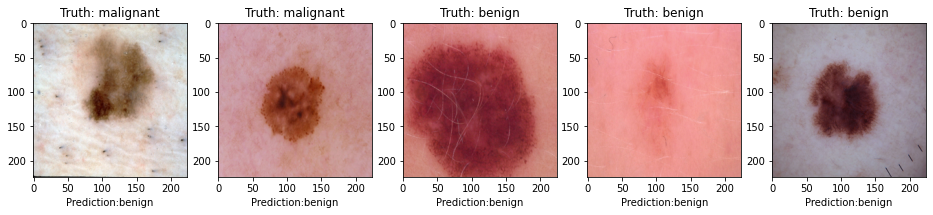

In [ ]:
fig = plt.figure(figsize=(16,16))
cols = 5
rows = 1

for i in range(1, cols*rows + 1):

  df_row = random.randint(0,len(test_df)-1)
  img_path = test_df.iloc[df_row,0]
  class_name = test_df.iloc[df_row,1]

  ax = fig.add_subplot(rows, cols, i)
  ax.set_title("Truth: " + class_name)

  single_test_img = image.load_img(img_path, target_size=(299,299))
  x = image.img_to_array(single_test_img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  pred = model_scratch_CNN.predict(x)
  # print(pred)
  if pred[0][0] > pred[0][1]:
    pred_name = 'benign'
  else:
    pred_name = 'malignant'
  ax.set_xlabel("Prediction:" + pred_name)

  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

It appears that the model predicts all the images to be `benign`, just like our `Inception-ResNet-V2` did. Let us now evaluate it on the whole dataset.

In [ ]:
preds_scratch_CNN = model_scratch_CNN.predict(test_dataset, batch_size=batch_size, steps = 10, verbose = 1)
preds_scratch_CNN = preds_scratch_CNN.argmax(axis=-1)
preds_scratch_CNN.shape

10/10 [==============================] - 6s 214ms/step


(640,)

In [ ]:
test_labels = test_df[:preds_scratch_CNN.shape[0]]['class'].to_list()

In [ ]:
recall_score_scratch_CNN = recall_score(test_labels, preds_scratch_CNN)
print(recall_score_scratch_CNN)

0.0


In [ ]:
conf_mat_scratch_CNN = confusion_matrix(test_labels, preds_scratch_CNN)

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


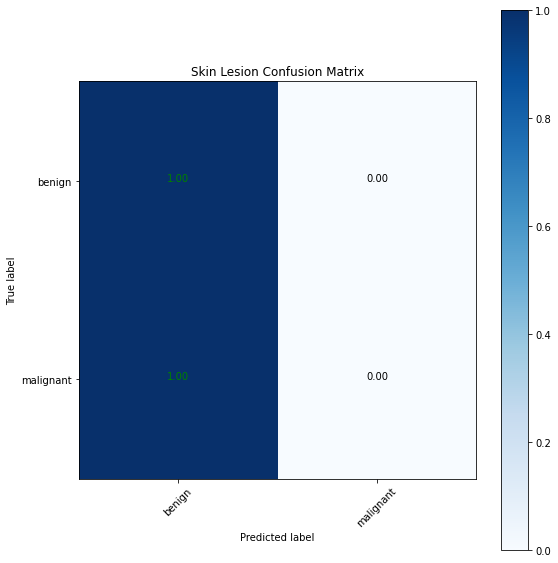

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(conf_mat_scratch_CNN, cm_plot_labels, normalize=True,
                      title='Skin Lesion Confusion Matrix')

plt.show()

Just like the `Inception-ResNet-V2`, our CNN that is built from scratch is unable to generalize to the unseen test data too. The CNN predicts all the test images to be `benign` and has a test recall score of 0.

The CNN built from scratch has both training and validation recall score at about 0.55 which is not very high. These results are similar to that of the `Inception-ResNet-V2`.

## Conclusion

In conclusion, the 3 models we have attempted did not perform very well in this skin lesion image classification project. The images have proved to be difficult to differentiate.

In both the `Inception-ResNet-V2` and CNN that we built from scratch, they may not have captured the patterns in the images of the 2 classes in the training data. There isn't a case of overfitting as the training recall score and validation recall scores are the same. Notably, both models failed completely when evaluated against the unseen test data. They predicted all images to be `benign` when there are test images from the `malignant` class as well. As a result, both achieved a test recall score of 0.

Although our `EfficientNetB1` performed poorly, it is still the best performing model among the 3 models. `EfficientNetB1` is part of a class of deep learning technique called `EfficientNet` that is only very recently developed. Therefore, its architecture may have allowed it to be stronger in learning patterns from data. In our project, where our `Inception-ResNet-V2` and CNN have failed, `EfficientNetV2` is able to achieve a validation recall score of about 0.8 and a test recall score of between 0.5 and 0.6. It was able to at least classify some of the images correctly.

Models aside, it may also be the case that there may be more data preprocessing needed to improve the model training and hence model performance. For example, we may attempt data augmentation to provide the models with more, varied training examples in the hopes that they will learn more patterns and be able to generalize better.